In [1]:
import ast
import pandas as pd
import re
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
import torch.nn.functional as F
import torch.nn as nn
from pytorch_lightning import Trainer
from sklearn.model_selection import train_test_split
from pytorch_lightning.callbacks import ModelCheckpoint

In [47]:
def read_knot_data(filename):
    records = []
    
    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            # 1) Convert curly braces to square brackets
            line = line.replace('{', '[').replace('}', ']')
            
            # 2) Convert Mathematica *^ floats to Python e floats
            #    Do each sign separately, then default to no sign
            line = line.replace('*^-', 'e-')
            line = line.replace('*^+', 'e+')
            line = line.replace('*^', 'e')
            
            # 3) literal_eval
            data = ast.literal_eval(line)
            records.append(data)
    
    # Create DataFrame
    df = pd.DataFrame(records, columns=["knot_name", "J_zeros", "C_zeros", "volume"])
    return df

In [48]:
df_knots=read_knot_data("nameJ2zerosJ3zerosvol.txt")

Epoch 0: 100%|█| 17730/17730 [11:25:19<00:00,  0.43it/s, v_num=12, mse_loss=0.12

                                                                                

In [49]:
def sort_complex_pairs(pair_list):
    """
    Given a list of [real, imag] pairs, 
    sort them first by real component, then by imaginary component.
    """
    if not pair_list:
        return pair_list
    # Use Python's built-in 'sorted' with a tuple (real, imag) as the key
    return sorted(pair_list, key=lambda pair: (pair[0], pair[1]))

In [50]:
df_knots['J_zeros'] = df_knots['J_zeros'].apply(sort_complex_pairs)
df_knots['C_zeros'] = df_knots['C_zeros'].apply(sort_complex_pairs)

In [51]:
df_knots.head()

,knot_name,J_zeros,C_zeros,volume
0,4_1,"[[-0.3090169943749479, -0.9510565162951543], [...","[[-0.9713385871308796, -0.2377001244227466], [...",2.029883
1,5_2,"[[-0.33911004330436717, -0.8223754344096812], ...","[[-1.0758734219330786, -0.36954428316759746], ...",2.828122
2,6_1,"[[-0.40662961271472337, -0.7490398002735331], ...","[[-1.0198202123407993, -0.3943807100072422], [...",3.163963
3,6_2,"[[-0.49883183995589636, -1.001302556337741], [...","[[-1.0522537067062143, -0.36270316966133176], ...",4.400833
4,6_3,"[[-0.40096886790241876, -0.9160916804409108], ...","[[-1.1795647308385209, 0], [-0.914211156015100...",5.693021


In [52]:
class KnotsDataset(Dataset):
    def __init__(self, df_knots, input_col='C_zeros', target_col='J_zeros'):
        """
        df_knots: a pandas DataFrame.
        input_col: name of the column containing the input list of [re, im] pairs.
        target_col: name of the column containing the target list of [re, im] pairs.
        """
        self.df_knots = df_knots.reset_index(drop=True)
        self.input_col = input_col
        self.target_col = target_col

    def __len__(self):
        return len(self.df_knots)

    def __getitem__(self, idx):
        """
        Return (x, y) where x is the list of [re, im] for J_roots_pos_imag,
        and y is the list of [re, im] for C_roots_pos_imag.
        """
        row = self.df_knots.iloc[idx]
        x = row[self.input_col]  # a list of [real, imag]
        y = row[self.target_col] # a list of [real, imag]
        return x, y

In [53]:
import torch
from torch.utils.data import DataLoader

def knots_collate_fn(batch):
    """
    batch: list of (x, y), where:
      x is a list of [re, im] floats,
      y is a list of [re, im] floats.

    Returns:
      x_tensor: (batch_size, max_len, 2) float
      x_mask:   (batch_size, max_len) bool  (True=valid, False=pad)
      y_tensor: (batch_size, max_len, 3) float
                where [re, im, 0] = valid
                      [0,  0,  1] = padded
    """
    # Separate out all x and y
    x_list = [item[0] for item in batch]  # list of lists of [re, im]
    y_list = [item[1] for item in batch]

    batch_size = len(batch)
    # Find the maximum lengths
    max_len_x = max((len(x_seq) for x_seq in x_list), default=0)
    max_len_y = max((len(y_seq) for y_seq in y_list), default=0)
    max_len   = max(max_len_x, max_len_y)  # unify so we can compare 1:1

    # Create tensors
    x_tensor = torch.zeros((batch_size, max_len, 2), dtype=torch.float)
    x_mask   = torch.zeros((batch_size, max_len), dtype=torch.bool)

    # For y, we have an extra dimension for the "valid/pad" flag
    y_tensor = torch.zeros((batch_size, max_len, 3), dtype=torch.float)

    # Fill each row
    for i, (x_seq, y_seq) in enumerate(zip(x_list, y_list)):
        # --- Inputs ---
        Lx = len(x_seq)
        for j in range(Lx):
            re_val, im_val = x_seq[j]
            x_tensor[i, j, 0] = re_val
            x_tensor[i, j, 1] = im_val
            x_mask[i, j] = True  # Mark valid

        # --- Targets ---
        Ly = len(y_seq)
        for j in range(Ly):
            re_val, im_val = y_seq[j]
            y_tensor[i, j, 0] = re_val
            y_tensor[i, j, 1] = im_val
            y_tensor[i, j, 2] = 0.0  # 0 => valid token

        # Pad the remainder of y with an indicator 1.0 => padded
        for j in range(Ly, max_len):
            y_tensor[i, j, 2] = 1.0  # 1 => padded

    return x_tensor, x_mask, y_tensor

In [54]:
train_df, valtest_df = train_test_split(df_knots, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(valtest_df, test_size=0.5, random_state=42)

train_dataset = KnotsDataset(train_df, input_col='C_zeros', target_col='J_zeros')
val_dataset = KnotsDataset(val_df, input_col='C_zeros', target_col='J_zeros')
test_dataset = KnotsDataset(test_df, input_col='C_zeros', target_col='J_zeros')

In [55]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0, collate_fn=knots_collate_fn)#, multiprocessing_context="forkserver", persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True, num_workers=0, collate_fn=knots_collate_fn)#, multiprocessing_context="forkserver", persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers=0, collate_fn=knots_collate_fn)#, multiprocessing_context="forkserver", persistent_workers=True)

In [56]:
print("Train size:", len(train_df))
print("Val size:", len(val_df))
print("Test size:", len(test_df))

Train size: 141836
Val size: 17730
Test size: 17730


In [57]:
class KnotsEncoderModel(nn.Module):
    def __init__(
        self,
        d_model=64,
        nhead=4,
        num_layers=2,
        dim_feedforward=128,
        dropout=0.1
    ):
        """
        A simple encoder-only Transformer:
          - Embeds 2D inputs ([re, im]) to dimension d_model.
          - Stacks num_layers of TransformerEncoder.
          - Projects back down to 3D (e.g. [re, im, validity]).
        
        Reasonable defaults for M1 Max:
          d_model=64, nhead=4, num_layers=2, etc.
        """
        super().__init__()

        # 1) Linear embedding from 2 -> d_model
        self.embedding = nn.Linear(2, d_model)

        # 2) Build the TransformerEncoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True   # So input is [batch, seq_len, d_model]
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # 3) Output layer from d_model -> 3
        self.output_fc = nn.Linear(d_model, 3)

    def forward(self, x, x_mask):
        """
        Args:
          x: (batch_size, seq_len, 2) float tensor
          x_mask: (batch_size, seq_len) bool tensor, where True=valid, False=pad.
        
        Returns:
          out: (batch_size, seq_len, 3) float tensor
        """
        # We invert x_mask because the Transformer wants
        # a 'padding mask' with True=PAD, False=valid.
        src_key_padding_mask = ~x_mask  # shape [batch_size, seq_len]

        # 1) Embed
        emb = self.embedding(x)  # (batch_size, seq_len, d_model)

        # 2) Pass through encoder
        enc_out = self.encoder(
            emb, 
            src_key_padding_mask=src_key_padding_mask  # shape [batch_size, seq_len]
        )  # (batch_size, seq_len, d_model)

        # 3) Final projection to 3D
        out = self.output_fc(enc_out)  # (batch_size, seq_len, 3)

        return out

In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl

class KnotsEncoderLightning(pl.LightningModule):
    def __init__(
        self,
        d_model=64,
        nhead=4,
        num_layers=2,
        dim_feedforward=128,
        dropout=0.1,
        lr=1e-3
    ):
        super().__init__()
        self.save_hyperparameters()
        # This is the encoder-only model we defined earlier.
        self.model = KnotsEncoderModel(
            d_model=d_model,
            nhead=nhead,
            num_layers=num_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout
        )
        self.lr = lr  # Learning rate

    def forward(self, x, x_mask):
        """
        x:       (batch_size, seq_len, 2)
        x_mask:  (batch_size, seq_len) bool, True=valid
        returns: (batch_size, seq_len, 3)  [re_pred, im_pred, pad_pred_logit]
        """
        return self.model(x, x_mask)

    def training_step(self, batch, batch_idx):
        # batch should be (x_tensor, x_mask, y_tensor) from your collate_fn
        x_tensor, x_mask, y_tensor = batch  # y_tensor shape: (B, L, 3)

        # Forward pass
        pred = self(x_tensor, x_mask)   # (B, L, 3)
        pred_re  = pred[..., 0]         # real part
        pred_im  = pred[..., 1]         # imag part
        pred_pad = pred[..., 2]         # logit for "is padded?" (will apply sigmoid or BCE)

        # Ground truth
        true_re  = y_tensor[..., 0]
        true_im  = y_tensor[..., 1]
        true_pad = y_tensor[..., 2]  # 0 => valid, 1 => padded

        # 1) MSE loss for valid tokens only
        #    If true_pad=0 => valid token => compute MSE
        #    If true_pad=1 => padded => ignore
        valid_mask = (true_pad < 0.5)  # bool of shape (B, L)
        # We'll gather only the valid positions
        pred_re_valid = pred_re[valid_mask]
        pred_im_valid = pred_im[valid_mask]
        true_re_valid = true_re[valid_mask]
        true_im_valid = true_im[valid_mask]
        
        if pred_re_valid.numel() > 0:
            mse_loss_re = F.mse_loss(pred_re_valid, true_re_valid)
            mse_loss_im = F.mse_loss(pred_im_valid, true_im_valid)
            mse_loss = (mse_loss_re + mse_loss_im) * 0.5
        else:
            mse_loss = torch.tensor(0.0, device=self.device)

        # 2) BCE loss on the pad dimension
        #    We interpret pred_pad as a logit for "is padded? (1) vs. valid? (0)"
        #    So we want to match 'true_pad' in {0,1}
        bce_loss = F.binary_cross_entropy_with_logits(
            pred_pad, true_pad
        )

        # Combine them (you can weight them differently if desired)
        loss = mse_loss + bce_loss

        self.log('train_loss', loss)
        self.log('mse_loss', mse_loss, prog_bar=True)
        self.log('bce_loss', bce_loss, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        # Similar to training_step, but we might log val_loss
        x_tensor, x_mask, y_tensor = batch
        pred = self(x_tensor, x_mask)
        pred_re  = pred[..., 0]
        pred_im  = pred[..., 1]
        pred_pad = pred[..., 2]
        
        true_re  = y_tensor[..., 0]
        true_im  = y_tensor[..., 1]
        true_pad = y_tensor[..., 2]

        valid_mask = (true_pad < 0.5)
        pred_re_valid = pred_re[valid_mask]
        pred_im_valid = pred_im[valid_mask]
        true_re_valid = true_re[valid_mask]
        true_im_valid = true_im[valid_mask]

        if pred_re_valid.numel() > 0:
            mse_loss_re = F.mse_loss(pred_re_valid, true_re_valid)
            mse_loss_im = F.mse_loss(pred_im_valid, true_im_valid)
            mse_loss = 0.5*(mse_loss_re + mse_loss_im)
        else:
            mse_loss = torch.tensor(0.0, device=self.device)

        bce_loss = F.binary_cross_entropy_with_logits(pred_pad, true_pad)
        loss = mse_loss + bce_loss

        self.log("val_loss", loss, on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

In [59]:
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",       # which metric to monitor
    mode="min",               # we want to minimize val_loss
    save_top_k=1,             # only save the best checkpoint
    filename="knots-{epoch:02d}-{val_loss:.4f}"
)

In [60]:
import os

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [ ]:
model = KnotsEncoderLightning()
trainer = pl.Trainer(
    max_epochs=10,       # e.g. 10 epochs
    accelerator="cpu",   # or "gpu" / "mps" if appropriate
    callbacks=[checkpoint_callback]
)
trainer.fit(model, train_loader, val_loader)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/hughes/miniforge3/envs/transformer/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | KnotsEncoderModel | 67.3 K | train
----------------------------------------------------
67.3 K    Trainable params
0         Non-trainable params
67.3 K    Total params
0.269     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


/Users/hughes/miniforge3/envs/transformer/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:476: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/Users/hughes/miniforge3/envs/transformer/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/hughes/miniforge3/envs/transformer/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 0: 100%|█| 17730/17730 [09:34<00:00, 30.89it/s, v_num=15, mse_loss=0.166, 
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████| 2217/2217 [01:25<00:00, 25.91it/s]
Epoch 1: 100%|█| 17730/17730 [19:04<00:00, 15.49it/s, v_num=15, mse_loss=0.131, 
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████| 2217/2217 [02:35<00:00, 14.26it/s]
Epoch 2: 100%|█| 17730/17730 [31:55<00:00,  9.25it/s, v_num=15, mse_loss=0.161, 
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████| 2217/2217 [02:36<00:00, 14.20it/s]
Epoch 3: 100%|█| 17730/17730 [46:58<00:00,  6.29it/s, v_num=15, mse_loss=0.161, 
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████| 2217/2217 [02:34<00:00, 14.30it/s]
Epoch 4:  14%|▏| 2426/17730 

In [14]:
best_ckpt_path = checkpoint_callback.best_model_path
print(f"Best checkpoint saved at: {best_ckpt_path}")

# Create a new instance of the same model class, then load the weights:
best_model = KnotsEncoderLightning.load_from_checkpoint(best_ckpt_path)
best_model.eval()

Best checkpoint saved at: 


NameError: name 'KnotsEncoderLightning' is not defined

In [106]:
def keep_positive_imag_roots(roots, tol=1e-9):
    """
    roots: list of [real_part, imag_part]
    tol: floating-point tolerance for deciding if a root is 'real' 
         (i.e., imag_part is effectively 0).

    Returns a new list that includes:
      - Any root whose |imag_part| <= tol (treat as real).
      - Any root whose imag_part > tol (strictly positive imaginary part).
    """
    filtered = []
    for re, im in roots:
        if abs(im) <= tol:
            # Root is effectively real
            filtered.append([re, 0.0])  # Or just keep im as is, your choice
        elif im > tol:
            # Positive imaginary part
            filtered.append([re, im])
        # else: negative imaginary part -> discard
    return filtered

In [107]:
def add_filtered_columns(df, eps=1e-9):
    """
    For each row in the given DataFrame, apply filter_conjugates to J_zeros and C_zeros.
    Save them into new columns 'J_roots_pos_imag' and 'C_roots_pos_imag'.
    """
    df['J_roots_pos_imag'] = df['J_zeros'].apply(lambda roots: keep_positive_imag_roots(roots, eps))
    df['C_roots_pos_imag'] = df['C_zeros'].apply(lambda roots: keep_positive_imag_roots(roots, eps))
    return df

In [108]:
def complex_mean_as_list(pairs):
    """
    Given a list of [re, im] pairs, treat each as a complex number re + i*im,
    and compute the average (mean).

    Returns [mean_real, mean_imag] as floats, or [np.nan, np.nan] if empty.
    """
    if not pairs:
        return [np.nan, np.nan]
    
    # Convert to a NumPy array of shape (n, 2).
    arr = np.array(pairs, dtype=float)
    
    # Return [real_part, imag_part].
    return np.mean(arr,axis=0)

# Now assume df_knots has these columns:
#   df_knots['J_zeros']
#   df_knots['C_zeros']
#   df_knots['J_roots_pos_imag']
#   df_knots['C_roots_pos_imag']
# Each entry is a list of [real_part, imag_part] pairs.

# Create four new columns with the complex means, stored as [re, im] lists.
df_knots['mean_J_all'] = df_knots['J_zeros'].apply(complex_mean_as_list)
df_knots['mean_C_all'] = df_knots['C_zeros'].apply(complex_mean_as_list)
df_knots['mean_J_filtered'] = df_knots['J_roots_pos_imag'].apply(complex_mean_as_list)
df_knots['mean_C_filtered'] = df_knots['C_roots_pos_imag'].apply(complex_mean_as_list)

In [102]:
df_knots['J_roots_pos_imag'] = df_knots['J_roots_pos_imag'].apply(sort_complex_pairs)
df_knots['C_roots_pos_imag'] = df_knots['C_roots_pos_imag'].apply(sort_complex_pairs)
df_knots['J_zeros'] = df_knots['J_zeros'].apply(sort_complex_pairs)
df_knots['C_zeros'] = df_knots['C_zeros'].apply(sort_complex_pairs)

In [103]:
df_knots.loc[200,"J_zeros"]

[[-0.5068964261346006, -0.8946719734811437],
 [-0.5068964261346006, 0.8946719734811437],
 [0.017656949489353473, -0.8596059209285779],
 [0.017656949489353473, 0.8596059209285779],
 [0.26752071517824433, -0.9136387911138572],
 [0.26752071517824433, 0.9136387911138572],
 [0.5754449005492627, -0.15490921878433367],
 [0.5754449005492627, 0.15490921878433367],
 [1.351515042941653, 0],
 [2.9410326788911187, 0]]

In [104]:
df_knots.loc[200,"C_zeros"]

[[-1.3180882607077324, 0],
 [-1.1123951802998402, 0],
 [-0.972656194468952, -0.404708099681074],
 [-0.972656194468952, 0.404708099681074],
 [-0.8971299116359019, -0.3239058092629384],
 [-0.8971299116359019, 0.3239058092629384],
 [-0.8684083456919289, -0.6307140863664507],
 [-0.8684083456919289, 0.6307140863664507],
 [-0.856360448927122, -0.07283426495686256],
 [-0.856360448927122, 0.07283426495686256],
 [-0.0006384810298199358, -1.0003076226143315],
 [-0.0006384810298199358, 1.0003076226143315],
 [0.11690170363404061, -0.6487291419079374],
 [0.11690170363404061, 0.6487291419079374],
 [0.30734908875633193, -0.9499925618352235],
 [0.30734908875633193, 0.9499925618352235],
 [0.5008620831788387, -0.8492383725511057],
 [0.5008620831788387, 0.8492383725511057],
 [0.6338590235517765, -0.18680835287718436],
 [0.6338590235517765, 0.18680835287718436],
 [0.6603484123466616, -0.7471006471735758],
 [0.6603484123466616, 0.7471006471735758],
 [0.7315949885860976, -0.1277501571599863],
 [0.7315949885

In [105]:
df_knots.loc[200,"J_roots_pos_imag"]

[[-0.5068964261346006, 0.8946719734811437],
 [0.017656949489353473, 0.8596059209285779],
 [0.26752071517824433, 0.9136387911138572],
 [0.5754449005492627, 0.15490921878433367],
 [1.351515042941653, 0.0],
 [2.9410326788911187, 0.0]]

In [96]:
df_knots.loc[200,"J_zeros"]

[[2.9410326788911187, 0],
 [1.351515042941653, 0],
 [-0.5068964261346006, -0.8946719734811437],
 [-0.5068964261346006, 0.8946719734811437],
 [0.26752071517824433, -0.9136387911138572],
 [0.26752071517824433, 0.9136387911138572],
 [0.017656949489353473, -0.8596059209285779],
 [0.017656949489353473, 0.8596059209285779],
 [0.5754449005492627, -0.15490921878433367],
 [0.5754449005492627, 0.15490921878433367]]

In [97]:
df_knots.loc[200,"J_roots_pos_imag"]

[[2.9410326788911187, 0.0],
 [1.351515042941653, 0.0],
 [-0.5068964261346006, 0.8946719734811437],
 [0.26752071517824433, 0.9136387911138572],
 [0.017656949489353473, 0.8596059209285779],
 [0.5754449005492627, 0.15490921878433367]]

In [98]:
df_knots.loc[200,"mean_J_all"]

array([0.5, 0. ])

In [99]:
df_knots.loc[200,"mean_J_filtered"]

array([0.77437898, 0.47047098])

In [25]:
class KnotsDataset(Dataset):
    def __init__(self, df_knots, input_col='J_roots_pos_imag', target_col='C_roots_pos_imag'):
        """
        df_knots: a pandas DataFrame.
        input_col: name of the column containing the input list of [re, im] pairs.
        target_col: name of the column containing the target list of [re, im] pairs.
        """
        self.df_knots = df_knots.reset_index(drop=True)
        self.input_col = input_col
        self.target_col = target_col

    def __len__(self):
        return len(self.df_knots)

    def __getitem__(self, idx):
        """
        Return (x, y) where x is the list of [re, im] for J_roots_pos_imag,
        and y is the list of [re, im] for C_roots_pos_imag.
        """
        row = self.df_knots.iloc[idx]
        x = row[self.input_col]  # a list of [real, imag]
        y = row[self.target_col] # a list of [real, imag]
        return x, y

In [27]:
def knots_collate_fn(batch):
    """
    batch: a list of (x, y), where:
       x = list of [real, imag] pairs
       y = list of [real, imag] pairs
    
    Returns:
      x_tensor: float tensor of shape [B, max_len_x, 2]
      x_mask:   bool tensor of shape [B, max_len_x] (True = valid, False = pad)
      y_tensor: float tensor of shape [B, max_len_y, 2]
      y_mask:   bool tensor of shape [B, max_len_y]
    """
    # 1) Find batch_size
    batch_size = len(batch)
    
    # Separate out all x and y
    x_list = [ex[0] for ex in batch]
    y_list = [ex[1] for ex in batch]

    # 2) Determine max lengths
    max_len_x = max(len(x) for x in x_list) if x_list else 0
    max_len_y = max(len(y) for y in y_list) if y_list else 0

    # 3) Prepare empty tensors of shape [batch_size, max_len, 2]
    x_tensor = torch.zeros(batch_size, max_len_x, 2, dtype=torch.float)
    y_tensor = torch.zeros(batch_size, max_len_y, 2, dtype=torch.float)

    # 4) Prepare attention masks
    #    Let's store True for valid, False for pad. 
    #    Some code does the opposite (1 for pad, 0 for valid)—be consistent with your model.
    x_mask = torch.zeros(batch_size, max_len_x, dtype=torch.bool)
    y_mask = torch.zeros(batch_size, max_len_y, dtype=torch.bool)

    # 5) Fill in each example
    for i, (x_seq, y_seq) in enumerate(zip(x_list, y_list)):
        # x_seq is a list of [real, imag], length Lx
        Lx = len(x_seq)
        if Lx > 0:
            x_tensor[i, :Lx, :] = torch.tensor(x_seq, dtype=torch.float)
            x_mask[i, :Lx] = True

        # y_seq is a list of [real, imag], length Ly
        Ly = len(y_seq)
        if Ly > 0:
            y_tensor[i, :Ly, :] = torch.tensor(y_seq, dtype=torch.float)
            y_mask[i, :Ly] = True

    return x_tensor, x_mask, y_tensor, y_mask

In [29]:
dataset = KnotsDataset(df_knots)
loader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=knots_collate_fn)

for batch in loader:
    x_tensor, x_mask, y_tensor, y_mask = batch
    print("x_tensor shape:", x_tensor.shape)  # [8, max_len_x, 2]
    print("x_mask shape:", x_mask.shape)      # [8, max_len_x]
    print("y_tensor shape:", y_tensor.shape)  # [8, max_len_y, 2]
    print("y_mask shape:", y_mask.shape)      # [8, max_len_y]
    break

x_tensor shape: torch.Size([8, 9, 2])
x_mask shape: torch.Size([8, 9])
y_tensor shape: torch.Size([8, 36, 2])
y_mask shape: torch.Size([8, 36])


In [51]:
class KnotsDataModule(pl.LightningDataModule):
    def __init__(self, 
                 train_df: pd.DataFrame, 
                 val_df: pd.DataFrame, 
                 test_df: pd.DataFrame, 
                 batch_size=8,
                 input_col='J_roots_pos_imag', 
                 target_col='C_roots_pos_imag'):
        super().__init__()
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.batch_size = batch_size
        self.input_col = input_col
        self.target_col = target_col
        
    def setup(self, stage=None):
        # Create Dataset objects from the splits
        if stage == 'fit' or stage is None:
            self.train_dataset = KnotsDataset(
                df_knots=self.train_df, 
                input_col=self.input_col, 
                target_col=self.target_col
            )
            self.val_dataset = KnotsDataset(
                df_knots=self.val_df, 
                input_col=self.input_col, 
                target_col=self.target_col
            )
        if stage == 'test' or stage is None:
            self.test_dataset = KnotsDataset(
                df_knots=self.test_df, 
                input_col=self.input_col, 
                target_col=self.target_col
            )

    def train_dataloader(self):
        return DataLoader(self.train_dataset, 
                          batch_size=self.batch_size, 
                          shuffle=True,
                          collate_fn=knots_collate_fn)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, 
                          batch_size=self.batch_size, 
                          collate_fn=knots_collate_fn)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, 
                          batch_size=self.batch_size, 
                          collate_fn=knots_collate_fn)

# --- EXAMPLE USAGE:

# 1) Suppose you have a df_knots with all rows. 
#    Manually split it (e.g. 80/10/10) via sklearn:

train_df, valtest_df = train_test_split(df_knots, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(valtest_df, test_size=0.5, random_state=42)

# 2) Create a DataModule from these splits:
dm = KnotsDataModule(train_df, val_df, test_df, batch_size=8)

# 3) Fit a LightningModule:
#    trainer = pl.Trainer(...)
#    trainer.fit(model, datamodule=dm)
#    trainer.test(model, datamodule=dm)

In [53]:
dm = KnotsDataModule(train_df, val_df, test_df, batch_size=8)

In [55]:
dm.setup()

In [57]:
train_loader = dm.train_dataloader()
test_loader = dm.test_dataloader()
val_loader = dm.val_dataloader()

In [58]:
list(train_loader)[1]

(tensor([[[-0.5052,  0.8494],
          [-0.1513,  1.0976],
          [ 0.0020,  0.8169],
          [ 0.4651,  0.0000],
          [ 0.4910,  0.5322],
          [ 0.5254,  1.0296],
          [ 1.1652,  0.0000],
          [ 1.6459,  0.0000]],
 
         [[ 0.4313,  1.8203],
          [ 1.4368,  0.0000],
          [ 0.1931,  1.0220],
          [-0.4925,  0.8790],
          [ 0.5288,  0.6560],
          [-0.0206,  0.8030],
          [ 0.7682,  0.0000],
          [ 0.5146,  0.0000]],
 
         [[ 1.5333,  0.2110],
          [ 0.2350,  1.3805],
          [-0.0294,  1.1202],
          [-0.5011,  0.8772],
          [ 0.6624,  0.6055],
          [ 0.2670,  0.7405],
          [ 0.6656,  0.0000],
          [ 0.0000,  0.0000]],
 
         [[ 1.4463,  1.3606],
          [ 1.1873,  0.0000],
          [-0.1006,  1.1278],
          [-0.4915,  0.8513],
          [ 0.5391,  0.7421],
          [-0.0020,  0.8130],
          [ 0.5151,  0.2115],
          [ 0.0000,  0.0000]],
 
         [[ 0.8166,  0.9534]

In [60]:
# Suppose df_knots is your full DataFrame
# e.g. columns: ['knot_name', 'J_zeros', 'C_zeros', 'J_roots_pos_imag', 'C_roots_pos_imag', ...]

# 1) 80% for train, 20% for val+test
train_df, valtest_df = train_test_split(df_knots, test_size=0.2, random_state=42)

# 2) Then split the valtest_df 50/50 -> 10% val, 10% test of the total
val_df, test_df = train_test_split(valtest_df, test_size=0.5, random_state=42)

print(f"Train size: {len(train_df)}, Val size: {len(val_df)}, Test size: {len(test_df)}")

Train size: 141836, Val size: 17730, Test size: 17730


In [62]:
class KnotsDataset(Dataset):
    def __init__(self, df_knots, input_col='J_roots_pos_imag', target_col='C_roots_pos_imag'):
        self.df_knots = df_knots.reset_index(drop=True)
        self.input_col = input_col
        self.target_col = target_col

    def __len__(self):
        return len(self.df_knots)

    def __getitem__(self, idx):
        row = self.df_knots.iloc[idx]
        x = row[self.input_col]  # list of [re, im]
        y = row[self.target_col] # list of [re, im]
        return x, y

def knots_collate_fn(batch):
    # Example collate that zero-pads sequences and creates masks.
    # (Adjust or use your previously defined version.)
    batch_size = len(batch)
    x_list = [item[0] for item in batch]
    y_list = [item[1] for item in batch]

    max_len_x = max(len(x) for x in x_list) if x_list else 0
    max_len_y = max(len(y) for y in y_list) if y_list else 0

    # Create zero-padded tensors
    x_tensor = torch.zeros((batch_size, max_len_x, 2), dtype=torch.float)
    y_tensor = torch.zeros((batch_size, max_len_y, 2), dtype=torch.float)

    # Create attention masks (True = valid, False = pad)
    x_mask = torch.zeros((batch_size, max_len_x), dtype=torch.bool)
    y_mask = torch.zeros((batch_size, max_len_y), dtype=torch.bool)

    for i, (x_seq, y_seq) in enumerate(zip(x_list, y_list)):
        if len(x_seq) > 0:
            x_tensor[i, :len(x_seq), :] = torch.tensor(x_seq, dtype=torch.float)
            x_mask[i, :len(x_seq)] = True
        if len(y_seq) > 0:
            y_tensor[i, :len(y_seq), :] = torch.tensor(y_seq, dtype=torch.float)
            y_mask[i, :len(y_seq)] = True

    return x_tensor, x_mask, y_tensor, y_mask

In [63]:
class KnotsDataModule(pl.LightningDataModule):
    def __init__(self, 
                 train_df, 
                 val_df, 
                 test_df,
                 batch_size=8,
                 input_col='J_roots_pos_imag',
                 target_col='C_roots_pos_imag'):
        super().__init__()
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.batch_size = batch_size
        self.input_col = input_col
        self.target_col = target_col

    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            self.train_dataset = KnotsDataset(self.train_df,
                                              input_col=self.input_col,
                                              target_col=self.target_col)
            self.val_dataset = KnotsDataset(self.val_df,
                                            input_col=self.input_col,
                                            target_col=self.target_col)
        if stage == 'test' or stage is None:
            self.test_dataset = KnotsDataset(self.test_df,
                                             input_col=self.input_col,
                                             target_col=self.target_col)

    def train_dataloader(self):
        return DataLoader(self.train_dataset,
                          batch_size=self.batch_size,
                          shuffle=True,
                          collate_fn=knots_collate_fn)
    def val_dataloader(self):
        return DataLoader(self.val_dataset,
                          batch_size=self.batch_size,
                          shuffle=False,
                          collate_fn=knots_collate_fn)
    def test_dataloader(self):
        return DataLoader(self.test_dataset,
                          batch_size=self.batch_size,
                          shuffle=False,
                          collate_fn=knots_collate_fn)

In [65]:
class KnotsModel(pl.LightningModule):
    def __init__(self, hidden_dim=32):
        super().__init__()
        # Example: a trivial linear layer that "predicts" from a single vector input
        # In practice, you’ll replace this with your transformer architecture.
        self.example_layer = nn.Linear(2, hidden_dim) 
        self.out_layer = nn.Linear(hidden_dim, 2)

    def forward(self, x, x_mask=None):
        """
        x: [batch_size, seq_len, 2]  (real, imag)
        x_mask: [batch_size, seq_len] (bool)

        For a real transformer, you'd embed each [re, im] into a higher dimension,
        then do multi-head attention, etc. 
        Here we do a simple placeholder.
        """
        # We'll flatten out the seq_len dimension just for a silly example:
        # shape (batch_size * seq_len, 2)
        batch_size, seq_len, _ = x.shape
        x_flat = x.view(batch_size * seq_len, 2)
        hidden = F.relu(self.example_layer(x_flat))
        out = self.out_layer(hidden)  # shape (batch_size * seq_len, 2)
        return out.view(batch_size, seq_len, 2)

    def training_step(self, batch, batch_idx):
        x_tensor, x_mask, y_tensor, y_mask = batch
        # forward pass
        pred = self(x_tensor, x_mask)
        # We'll just do an MSE loss vs. y_tensor
        loss = F.mse_loss(pred, y_tensor)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x_tensor, x_mask, y_tensor, y_mask = batch
        pred = self(x_tensor, x_mask)
        loss = F.mse_loss(pred, y_tensor)
        self.log('val_loss', loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x_tensor, x_mask, y_tensor, y_mask = batch
        pred = self(x_tensor, x_mask)
        loss = F.mse_loss(pred, y_tensor)
        self.log('test_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

In [68]:
# 1) Split DataFrame
train_df, valtest_df = train_test_split(df_knots, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(valtest_df, test_size=0.5, random_state=42)

# 2) Create DataModule
dm = KnotsDataModule(train_df, val_df, test_df,
                     batch_size=8,
                     input_col='J_roots_pos_imag',
                     target_col='C_roots_pos_imag')

# 3) Create model (placeholder)
model = KnotsModel(hidden_dim=32)

# 4) Create Trainer
trainer = Trainer(max_epochs=5)  # e.g. 5 epochs, CPU only for simplicity

# 5) Train
trainer.fit(model, dm)

# 6) Test
trainer.test(model, dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/hughes/miniforge3/envs/transformer/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name          | Type   | Params | Mode 
-------------------------------------------------
0 | example_layer | Linear | 96     | train
1 | out_layer     | Linear | 66     | train
-------------------------------------------------
162       Trainable params
0         Non-trainable params
162       Total params
0.001     Total 

Sanity Checking DataLoader 0:   0%|                       | 0/2 [00:00<?, ?it/s]

/Users/hughes/miniforge3/envs/transformer/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/var/folders/vt/4f227_c57k5fxr79wkfgxh5r0000gn/T/ipykernel_74726/2204539102.py:38: UserWarning: Using a target size (torch.Size([8, 44, 2])) that is different to the input size (torch.Size([8, 8, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(pred, y_tensor)


RuntimeError: The size of tensor a (8) must match the size of tensor b (44) at non-singleton dimension 1

In [69]:
df_knots.head()

,knot_name,J_zeros,C_zeros,volume,J_roots_pos_imag,C_roots_pos_imag,mean_J_all,mean_C_all,mean_J_filtered,mean_C_filtered
0,4_1,"[[-0.3090169943749479, -0.9510565162951543], [...","[[1.147115126315748, -0.4377033985664327], [1....",2.029883,"[[-0.3090169943749479, 0.9510565162951543], [0...","[[1.147115126315748, 0.4377033985664327], [-0....","[0.24999999999999983, 0.0]","[0.08333333333333266, 0.0]","[0.24999999999999983, 0.7694208842938136]","[0.08333333333333268, 0.549825468337819]"
1,5_2,"[[0.4556971463537512, -1.200152096461302], [0....","[[0.8022946724429645, -1.0189748088224135], [0...",2.828122,"[[0.4556971463537512, 1.200152096461302], [-0....","[[0.8022946724429645, 1.0189748088224135], [-1...","[0.2000000000000001, 0.0]","[0.06666666666666433, 0.0]","[0.2944709656502055, 0.674175843623661]","[0.005523618477508457, 0.5580202615297752]"
2,6_1,"[[0.07475104640853644, -1.2940511552254053], [...","[[0.23828627299108507, -1.2179129274123937], [...",3.163963,"[[0.07475104640853644, 1.2940511552254053], [0...","[[0.23828627299108507, 1.2179129274123937], [-...","[0.16666666666666674, 0.0]","[0.055555555555555754, 0.0]","[0.16666666666666674, 0.7999739537136552]","[0.055555555555555754, 0.5989981925126329]"
3,6_2,"[[0.28492014549902717, -1.1151405597204158], [...","[[-0.9169066951818676, -0.6468000055331047], [...",4.400833,"[[0.28492014549902717, 1.1151405597204158], [-...","[[-0.9169066951818676, 0.6468000055331047], [-...","[0.1666666666666671, 0.0]","[0.05555555555555521, 0.0]","[0.1666666666666671, 0.8074272794674872]","[0.05555555555555522, 0.57473259613538]"
4,6_3,"[[1.6355731299222214, 0], [0.27747906604368533...","[[1.435111800437746, -0.08824301780343402], [1...",5.693021,"[[1.6355731299222214, 0.0], [0.277479066043685...","[[1.435111800437746, 0.08824301780343402], [-1...","[0.33333333333333354, 0.0]","[0.11111111111108223, 0.0]","[0.5308724504646838, 0.4692058410147337]","[-0.0013667538422755365, 0.43452651042731816]"


In [73]:
df_knots["mean_C_filtered"].values

array([array([0.08333333, 0.54982547]), array([0.00552362, 0.55802026]),
       array([0.05555556, 0.59899819]), ...,
       array([-0.04683045,  0.2213234 ]), array([0.05963574, 0.43908279]),
       array([0.05832346, 0.57878588])], dtype=object)

In [87]:
x_values, y_values = zip(*df_knots["mean_C_filtered"].values)

<function matplotlib.pyplot.show(close=None, block=None)>

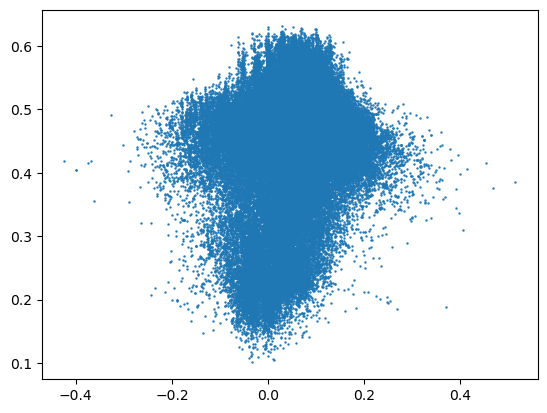

In [88]:
import matplotlib.pyplot as plt

plt.scatter(x_values, y_values, s=0.51)

plt.show